In [16]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import nltk

DF = pd.read_csv('/Users/ozgeyavuz/470 project/Autor_detection.csv')
DF.head()

#stopworldslerin analizi yanlış yönlendirmesini engellemek için
nltk.download('stopwords')

# counts = DF['Writter name'].value_counts()
# print("max: ", counts.max(),"- min: ", counts.min(),"- mean: ", counts.mean() , "std: ", counts.std())

# counts_greater_100 = counts[counts > 100]
# print("Number of authors with more than 100 samples: ", counts_greater_100)

# counts_greater_120 = counts[counts > 120]
# print("Number of authors with more than 120 samples: ", counts_greater_120)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ozgeyavuz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
#-------------ALL FUNCTİONS--------------   
def clean_and_std_data(df):

    df = df.dropna(subset=['Quotes'])

    def is_english(text):
        try:
            text.encode("ascii")
            return True
        except UnicodeEncodeError:
            return False

    english_quotes = df[df['Quotes'].apply(lambda x: is_english(str(x)))]
    english_quotes['Quotes'] = english_quotes['Quotes'].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True).str.strip()

    print(f"Orijinal veri seti büyüklüğü: {len(df)}")
    print(f"İngilizce quotes sayısı: {len(english_quotes)}")
    print(f"Elenen quote sayısı: {len(df) - len(english_quotes)}")
    return english_quotes

def get_word_freqs(df,top = 20):
    STOP_WORDS = set(stopwords.words('english'))
    author_word_freqs = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        all_words = ' '.join(author_quotes).split()
        # Stop words'leri filtrele
        all_words = [word for word in all_words if word not in STOP_WORDS and len(word) > 1] 
        word_freq = pd.Series(all_words).value_counts().head(top)
        author_word_freqs[author] = word_freq
    return author_word_freqs


def get_avg_quote_length_for_author(df):
    author_avg_word_length = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        avg_length = author_quotes.apply(lambda x: len(x.split())).mean()
        author_avg_word_length[author] = avg_length
    return author_avg_word_length

def get_frequent_ngrams(df,n=2, top=20):
    STOP_WORDS = set(stopwords.words('english'))
    author_ngram_freqs = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        all_ngrams = []
        for quote in author_quotes:
            # Kelimeleri böl ve stop words'leri filtrele
            words = [word for word in quote.split() 
                    if word not in STOP_WORDS and len(word) > 1]
            
            if len(words) >= n:  # n-gram oluşturmak için yeterli kelime var mı 
                ngram_list = list(nltk.ngrams(words, n))
                all_ngrams.extend(ngram_list)

        if all_ngrams:
            ngram_freq = pd.Series(all_ngrams).value_counts().head(top)
            author_ngram_freqs[author] = ngram_freq
        else:
            author_ngram_freqs[author] = pd.Series()
            
    return author_ngram_freqs

def get_word_diversity_for_author(df):
    author_word_diversity = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        all_words = ' '.join(author_quotes).split()
        unique_words = set(all_words)
        diversity = len(unique_words) / len(all_words) if len(all_words) > 0 else 0
        author_word_diversity[author] = diversity
    return author_word_diversity

def get_author_uniqueness_score(df):
    """
    Her yazarın diğer yazarlara göre ne kadar benzersiz kelime kullandığını hesaplar
    """
    STOP_WORDS = set(stopwords.words('english'))

    all_authors_words = set()
    author_word_sets = {}
    
    # Her yazarın kelime setini oluştur
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        words = set(' '.join(author_quotes).split())
        # Stop words'leri çıkar
        words = {word for word in words if word not in STOP_WORDS and len(word) > 1}
        author_word_sets[author] = words
        all_authors_words.update(words)
    
    # Her yazar için benzersizlik skoru hesapla
    author_uniqueness = {}
    for author, words in author_word_sets.items():
        # Diğer yazarların kelimelerini topla
        other_authors_words = set()
        for other_author, other_words in author_word_sets.items():
            if other_author != author:
                other_authors_words.update(other_words)
        
        # Benzersiz kelimeler: Sadece bu yazarın kullandığı kelimeler
        unique_words = words - other_authors_words
        
        # Benzersizlik skoru: Yazarın benzersiz kelimelerinin toplam kelimelerine oranı
        uniqueness_score = len(unique_words) / len(words) if len(words) > 0 else 0
        author_uniqueness[author] = uniqueness_score 
    
    return author_uniqueness

def get_lwr_and_avg_world_len(df):
    #lwr = long word ratio

    STOP_WORDS = set(stopwords.words('english'))

    author_complexity = {}
    for author in df['Writter name'].unique():
        author_quotes = df[df['Writter name'] == author]['Quotes']
        
        # Ortalama kelime uzunluğu
        all_words = ' '.join(author_quotes).split()
        all_words = [word for word in all_words if word not in STOP_WORDS and len(word) > 1]
        avg_word_length = sum(len(word) for word in all_words) / len(all_words) if all_words else 0
        
        # Uzun kelime oranı (6+ karakter)
        long_words = [word for word in all_words if len(word) > 6]
        long_word_ratio = len(long_words) / len(all_words) if all_words else 0
        
        author_complexity[author] = {
            'avg_word_length': avg_word_length,
            'long_word_ratio': long_word_ratio
        }
    
    return pd.DataFrame.from_dict(author_complexity, orient='index')

def pick_writers(df,limit=120):
    counts = df['Writter name'].value_counts()
    selected_authors = counts[counts > limit].index
    filtered_df = df[df['Writter name'].isin(selected_authors)]
    print(f"Seçilen yazar sayısı: {len(selected_authors)}")
    print(f"Filtrelenmiş veri seti büyüklüğü: {len(filtered_df)}")
    return filtered_df

In [18]:
cleaned_DF = clean_and_std_data(DF)
print(cleaned_DF.head())
print("\n")
    
counts = cleaned_DF['Writter name'].value_counts()
print("max: ", counts.max(),"- min: ", counts.min(),"- mean: ", counts.mean() , "std: ", counts.std())
print("\n")

counts_greater_100 = counts[counts > 100]
print("Number of authors with more than 100 samples: ", counts_greater_100)
print("\n")

counts_greater_120 = counts[counts > 120]
print("Number of authors with more than 120 samples: ", counts_greater_120)


Orijinal veri seti büyüklüğü: 1571
İngilizce quotes sayısı: 1566
Elenen quote sayısı: 5
                                              Quotes      Writter name
0  reading kafka i sense that the elicited questi...  Alberto Manguel,
1  all animals are equal but some animals are mor...     George Orwell
2  i am old gandalf i dont look it but i am begin...    J.R.R. Tolkien
3  how can we live without our lives how will we ...    John Steinbeck
4  i was only foolin george i dont want no ketchu...    John Steinbeck


max:  191 - min:  1 - mean:  19.575 std:  41.691991459976265


Number of authors with more than 100 samples:  Writter name
Jane Austen            191
J.R.R. Tolkien         158
John Steinbeck         147
Charles Dickens        147
William Shakespeare    132
Ernest Hemingway       114
Name: count, dtype: int64


Number of authors with more than 120 samples:  Writter name
Jane Austen            191
J.R.R. Tolkien         158
John Steinbeck         147
Charles Dickens        147
Wil

/var/folders/z_/b7h4r8012hg406xrq_wqvw940000gn/T/ipykernel_1588/12327140.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  english_quotes['Quotes'] = english_quotes['Quotes'].str.lower().str.replace(r'[^a-zA-Z\s]', '', regex=True).str.strip()


In [19]:
# NaN double checkpoint
print("\nBoş string kontrolü:", cleaned_DF[cleaned_DF['Quotes'] == ''].shape[0])
print("pd.NA kontrolü:", cleaned_DF[cleaned_DF['Quotes'].isna()].shape[0])
print("np.nan kontrolü:", cleaned_DF[cleaned_DF['Quotes'].isnull()].shape[0])

#word_freq feature ekleme
word_freqs = get_word_freqs(cleaned_DF, top=20)
cleaned_DF["word_freqs"] = cleaned_DF['Writter name'].map(word_freqs)

#n=2 ve n=3 için ngram feature ekleme
bigrams = get_frequent_ngrams(cleaned_DF, n=2, top=20)
cleaned_DF["bigram_freqs"] = cleaned_DF['Writter name'].map(bigrams)
trigrams = get_frequent_ngrams(cleaned_DF, n=3, top=20)
cleaned_DF["trigram_freqs"] = cleaned_DF['Writter name'].map(trigrams)

#yazarın quotelarında kullandığı kelime çeşitliliğini represent eden feature ekleme
word_diversities = get_word_diversity_for_author(cleaned_DF)
cleaned_DF["word_diversity_"] = cleaned_DF['Writter name'].map(word_diversities)

#author uniquness score ekleme : get_author_uniqueness_score func altında feature tanımı bulunmakta
uniqueness_scores = get_author_uniqueness_score(cleaned_DF)
cleaned_DF["author_uniqueness_score"] = cleaned_DF['Writter name'].map(uniqueness_scores)   

#lwr ve avg word length ekleme, lwr: long word ratio
complexity_df = get_lwr_and_avg_world_len(cleaned_DF)
cleaned_DF = cleaned_DF.merge(complexity_df, left_on='Writter name', right_index=True, how='left')      


#avg quote length ekleme
avg_lengths = get_avg_quote_length_for_author(cleaned_DF)
cleaned_DF["avg_quote_length(by words)"] = cleaned_DF['Writter name'].map(avg_lengths)
cleaned_DF.head()   





Boş string kontrolü: 0
pd.NA kontrolü: 0
np.nan kontrolü: 0


,Quotes,Writter name,word_freqs,bigram_freqs,trigram_freqs,word_diversity_,author_uniqueness_score,avg_word_length,long_word_ratio,avg_quote_length(by words)
0,reading kafka i sense that the elicited questi...,"Alberto Manguel,",next 2 kafka 2 readin...,"(reading, kafka) 1 (something, ...","(reading, kafka, sense) 1 ...",0.901961,0.357143,7.100000,0.466667,51.000000
1,all animals are equal but some animals are mor...,George Orwell,one 11 man 10 would 8 l...,"(animals, equal) 4 (animal, shall)...","(whatever, goes, upon) 2 (great...",0.365700,0.280412,5.977364,0.356858,22.985507
2,i am old gandalf i dont look it but i am begin...,J.R.R. Tolkien,one 20 like 19 ring 19 s...,"(one, ring) 8 (said, bilbo) ...","(one, ring, rule) 3 (ring, rule, on...",0.256083,0.349872,5.287073,0.218764,31.734177
3,how can we live without our lives how will we ...,John Steinbeck,people 20 like 18 get 17 know ...,"(seemed, know) 4 (george, said) 3 ...","(make, feel, rich) 3 (along, work...",0.289151,0.328846,5.384538,0.235978,27.149660
4,i was only foolin george i dont want no ketchu...,John Steinbeck,people 20 like 18 get 17 know ...,"(seemed, know) 4 (george, said) 3 ...","(make, feel, rich) 3 (along, work...",0.289151,0.328846,5.384538,0.235978,27.149660


In [20]:
cleaned_DF = pick_writers(cleaned_DF,120)
cleaned_DF.head()

Seçilen yazar sayısı: 5
Filtrelenmiş veri seti büyüklüğü: 775


,Quotes,Writter name,word_freqs,bigram_freqs,trigram_freqs,word_diversity_,author_uniqueness_score,avg_word_length,long_word_ratio,avg_quote_length(by words)
2,i am old gandalf i dont look it but i am begin...,J.R.R. Tolkien,one 20 like 19 ring 19 s...,"(one, ring) 8 (said, bilbo) ...","(one, ring, rule) 3 (ring, rule, on...",0.256083,0.349872,5.287073,0.218764,31.734177
3,how can we live without our lives how will we ...,John Steinbeck,people 20 like 18 get 17 know ...,"(seemed, know) 4 (george, said) 3 ...","(make, feel, rich) 3 (along, work...",0.289151,0.328846,5.384538,0.235978,27.149660
4,i was only foolin george i dont want no ketchu...,John Steinbeck,people 20 like 18 get 17 know ...,"(seemed, know) 4 (george, said) 3 ...","(make, feel, rich) 3 (along, work...",0.289151,0.328846,5.384538,0.235978,27.149660
6,there is nothing i would not do for those who ...,Jane Austen,one 25 could 23 must 21 alwa...,"(everybody, else) 5 (jane, austen) ...","(else, perfectly, happy) 2 (truth, b...",0.254730,0.348817,6.133243,0.369467,25.732984
8,short cuts make long delays,J.R.R. Tolkien,one 20 like 19 ring 19 s...,"(one, ring) 8 (said, bilbo) ...","(one, ring, rule) 3 (ring, rule, on...",0.256083,0.349872,5.287073,0.218764,31.734177


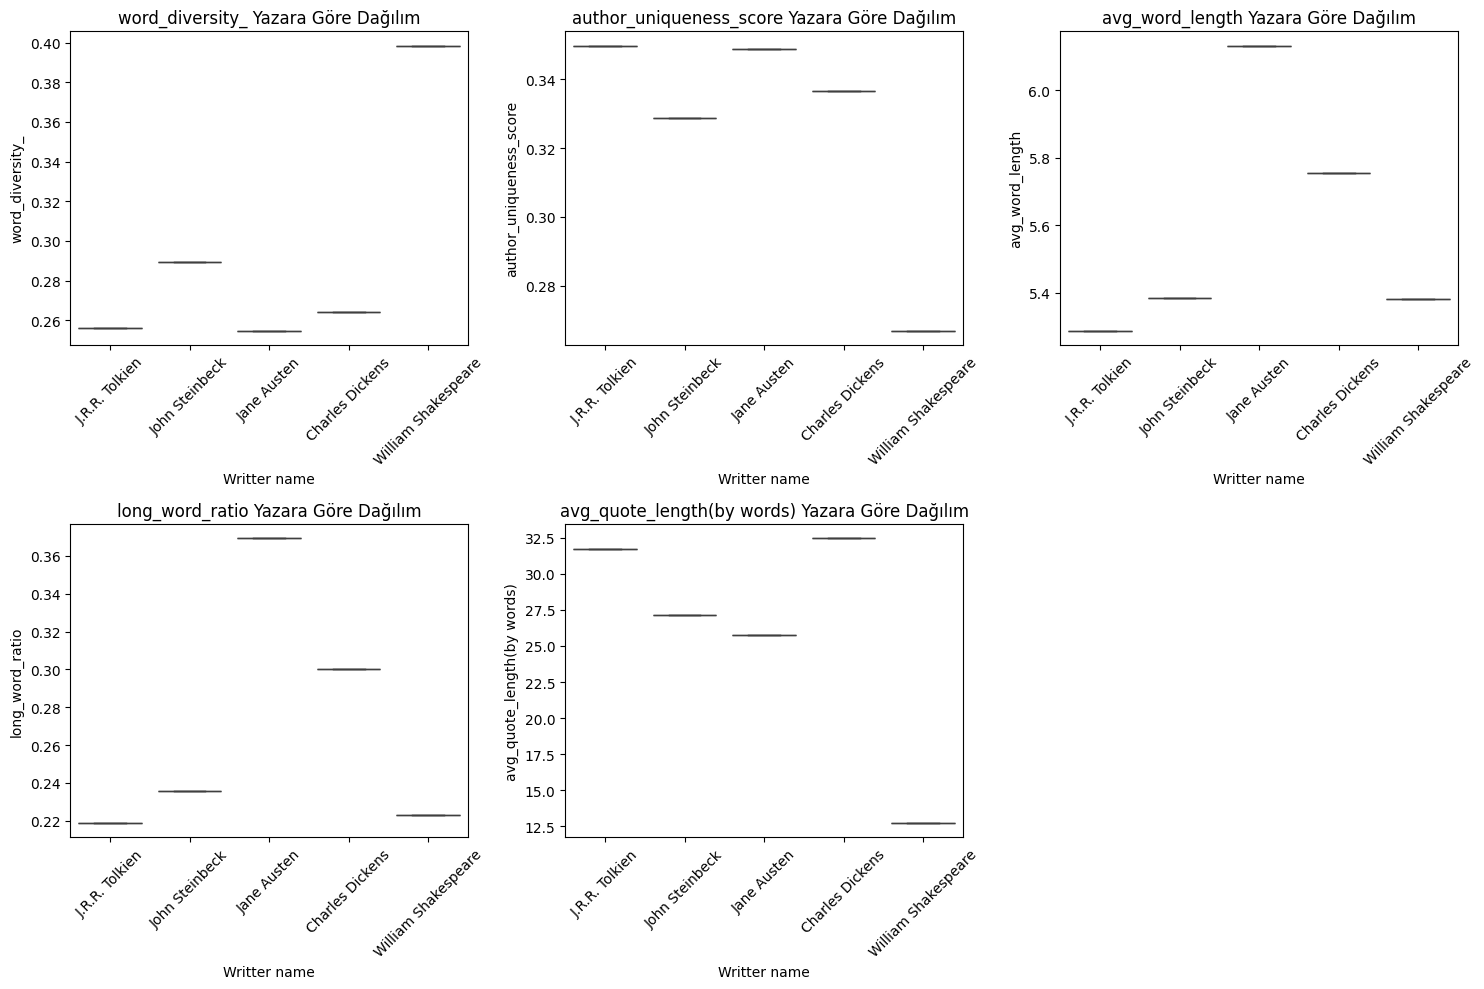

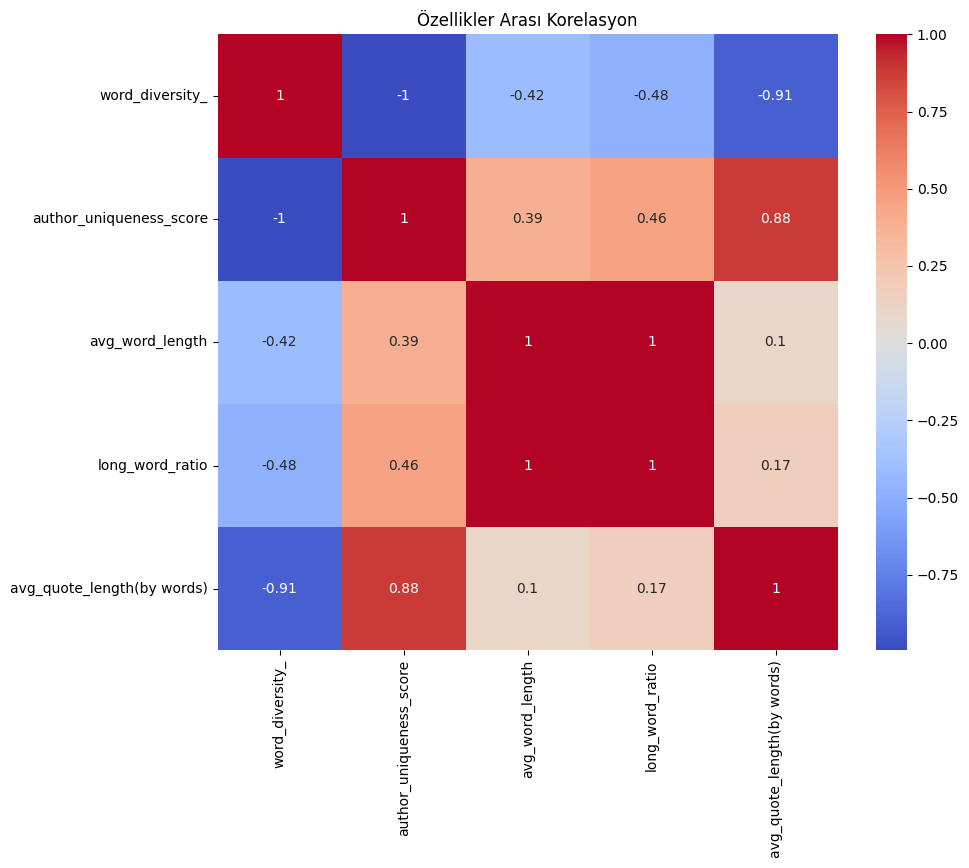


En Ayırt Edici Özellikler:
avg_word_length               0.265533
long_word_ratio               0.257123
word_diversity_               0.221378
author_uniqueness_score       0.141527
avg_quote_length(by words)    0.114440
dtype: float64


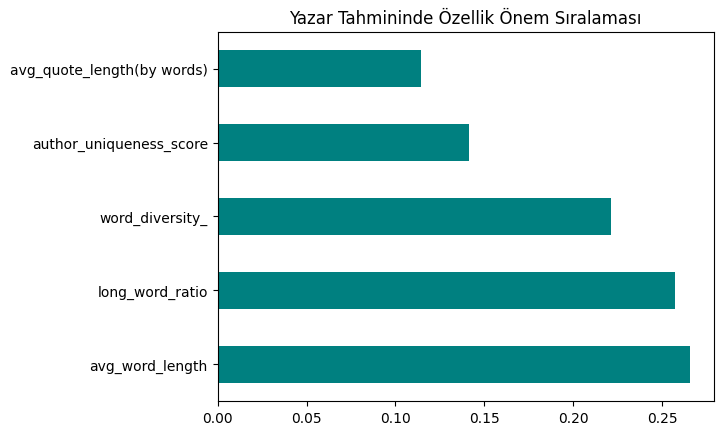

In [21]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# Verinin 'df' adında olduğunu varsayıyoruz
# Kategorik olmayan, sayısal sütunları seçelim
numeric_features = [
    'word_diversity_', 'author_uniqueness_score', 
    'avg_word_length', 'long_word_ratio', 'avg_quote_length(by words)'
]

# 1. Kutu Grafiği (Boxplot) Analizi
# Hangi özelliğin yazarlar arasında belirgin bir çizgi çektiğini gösterir
plt.figure(figsize=(15, 10))
for i, col in enumerate(numeric_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x='Writter name', y=col, data=cleaned_DF)
    plt.xticks(rotation=45)
    plt.title(f'{col} Yazara Göre Dağılım')

plt.tight_layout()
plt.show()

# 2. Korelasyon Matrisi
# Özelliklerin birbiriyle ne kadar ilişkili olduğunu anlamak için
plt.figure(figsize=(10, 8))
sns.heatmap(cleaned_DF[numeric_features].corr(), annot=True, cmap='coolwarm')
plt.title("Özellikler Arası Korelasyon")
plt.show()

# 3. Feature Importance (Hangi özellik yazarı daha iyi ayırt ediyor?)
X = cleaned_DF[numeric_features]
y = cleaned_DF['Writter name']

model = RandomForestClassifier()
model.fit(X, y)

importance = pd.Series(model.feature_importances_, index=numeric_features).sort_values(ascending=False)
print("\nEn Ayırt Edici Özellikler:")
print(importance)

# Görselleştirme
importance.plot(kind='barh', color='teal')
plt.title("Yazar Tahmininde Özellik Önem Sıralaması")
plt.show()